# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



1. Clean the data and perform some EDA and visualization to get to know the data set.

In [6]:
import pandas as pd

file_path = 'pierce_county_house_sales.csv'
house_data = pd.read_csv(file_path)

house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16814 entries, 0 to 16813
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sale_date                    16814 non-null  object
 1   sale_price                   16814 non-null  int64 
 2   house_square_feet            16814 non-null  int64 
 3   attic_finished_square_feet   16814 non-null  int64 
 4   basement_square_feet         16814 non-null  int64 
 5   attached_garage_square_feet  16814 non-null  int64 
 6   detached_garage_square_feet  16814 non-null  int64 
 7   fireplaces                   16814 non-null  int64 
 8   hvac_description             16807 non-null  object
 9   exterior                     16813 non-null  object
 10  interior                     16807 non-null  object
 11  stories                      16814 non-null  int64 
 12  roof_cover                   16806 non-null  object
 13  year_built                   16

In [5]:
house_data.head()

,sale_date,sale_price,house_square_feet,attic_finished_square_feet,basement_square_feet,attached_garage_square_feet,detached_garage_square_feet,fireplaces,hvac_description,exterior,interior,stories,roof_cover,year_built,bedrooms,bathrooms,waterfront_type,view_quality,utility_sewer
0,2020-01-02,380000,2157,0,0,528,0,0,Warm and Cool Air Zone,Frame Siding,Drywall,2,Composition Shingle,1993,3,3,NaN,NaN,SEWER/SEPTIC INSTALLED
1,2020-01-02,383000,2238,0,0,396,0,0,Forced Air,Frame Siding,Drywall,2,Composition Shingle,2017,4,3,NaN,NaN,SEWER/SEPTIC INSTALLED
2,2020-01-01,419900,1452,0,0,0,0,1,Forced Air,Frame Siding,Drywall,1,Built Up Rock,1965,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED
3,2020-01-02,251660,832,0,0,0,0,0,Forced Air,Frame Vinyl,Drywall,1,Composition Shingle,1919,2,1,NaN,NaN,SEWER/SEPTIC INSTALLED
4,2020-01-02,500000,1780,0,384,484,0,1,Forced Air,Frame Siding,Drywall,1,Composition Shingle,1955,3,2,NaN,NaN,SEWER/SEPTIC INSTALLED


In [10]:
missing_values = house_data.isnull().sum()
missing_values
# lots of missing values with waterfront_type and view_quality
# Some missing values with hvac_description, exterior, and interior

sale_date                          0
sale_price                         0
house_square_feet                  0
attic_finished_square_feet         0
basement_square_feet               0
attached_garage_square_feet        0
detached_garage_square_feet        0
fireplaces                         0
hvac_description                   7
exterior                           1
interior                           7
stories                            0
roof_cover                         8
year_built                         0
bedrooms                           0
bathrooms                          0
waterfront_type                16261
view_quality                   15895
utility_sewer                      0
dtype: int64

In [11]:
house_data_cleaned = house_data.drop(columns=['waterfront_type', 'view_quality'])

house_data_cleaned.dropna(inplace=True)

cleaned_na = house_data_cleaned.isnull().sum()
cleaned_na

sale_date                      0
sale_price                     0
house_square_feet              0
attic_finished_square_feet     0
basement_square_feet           0
attached_garage_square_feet    0
detached_garage_square_feet    0
fireplaces                     0
hvac_description               0
exterior                       0
interior                       0
stories                        0
roof_cover                     0
year_built                     0
bedrooms                       0
bathrooms                      0
utility_sewer                  0
dtype: int64

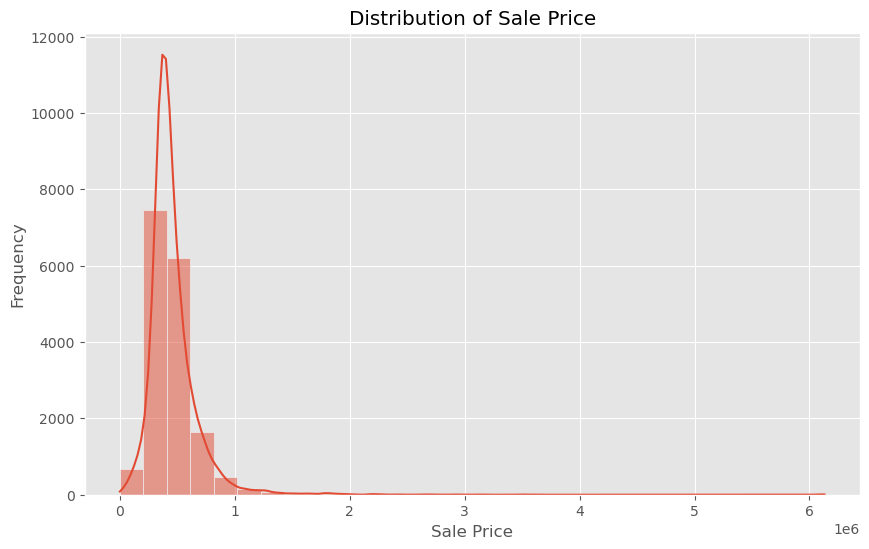

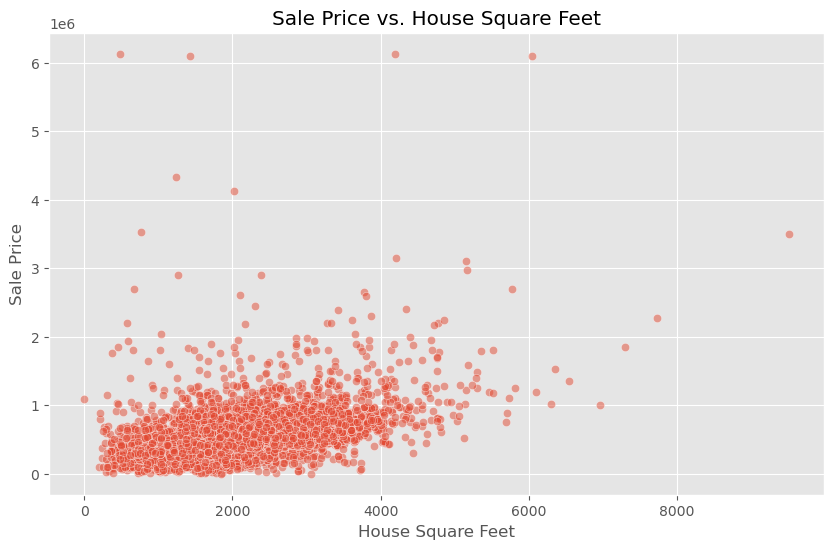

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizations

plt.figure(figsize=(10, 6))
sns.histplot(house_data_cleaned['sale_price'], kde=True, bins=30)
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='house_square_feet', y='sale_price', data=house_data_cleaned, alpha=0.5)
plt.title('Sale Price vs. House Square Feet')
plt.xlabel('House Square Feet')
plt.ylabel('Sale Price')
plt.show()


2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = house_data_cleaned.drop(columns=['sale_price', 'sale_date'])
y = house_data_cleaned['sale_price']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
    ], remainder='passthrough'
)

simple_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

3. Implement an ~80/~20 train-test split. Put the test data aside.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [25]:
simple_pipeline.fit(X_train, y_train)

y_train_pred = simple_pipeline.predict(X_train)
y_test_pred = simple_pipeline.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

# Based on the RMSE and R2 values, the model performs slightly better on the test data than the training data. 
# Usually, the model performs better on train set than test set, so this may be an indicator that our model is avoiding overfitting.

Training RMSE: 177707.5171442733
Test RMSE: 168620.1408550932
Training R^2: 0.4321519840806025
Test R^2: 0.4514162037394386


5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

complex_pipeline = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    LinearRegression()
)

complex_pipeline.fit(X_train, y_train)

y_train_pred_complex = complex_pipeline.predict(X_train)
y_test_pred_complex = complex_pipeline.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred_complex, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred_complex, squared=False)
train_r2 = r2_score(y_train, y_train_pred_complex)
test_r2 = r2_score(y_test, y_test_pred_complex)

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

# Seems like this complex model has very extreme overfitting, with a veyr big difference between the train set result and the test set result.
# This could mean that we included too many transformations that could end up negatively impacting our results.
# Adding too many transformations can lead to overfitting.
# Although, there could be ways that we can use a better model for overfitting.

Training RMSE: 152342.7768197401
Test RMSE: 551148967.7216414
Training R^2: 0.5826847560005539
Test R^2: -5860868.842124016


6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?

> My results from 1 to 5 showed the process of making a model to predict the sale price of houses based on the features on the data set. I started off using a simple linearly regression model with no transformations, which achieved a decent result that may be further sclaes to perform better. I than used a complex model with polynomial features, but this ended up overfitting, which means that having more compelx transformations may not always result in better predictive powers. In this case, the transformation ended up overfitting the data more. Furthermore, there may be other models that are better to solve this problem with overfitting, such as Lasso. I definitely learned a lot about overfitting, underfitting, and the importance of model selection in working with models.

7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.